In [ ]:
pip install rasterstats

In [ ]:
pip install h3

In [24]:
pip install mapclassify

   ---------------------------------------- 0.0/882.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/882.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/882.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/882.2 kB ? eta -:--:--
    --------------------------------------- 20.5/882.2 kB ? eta -:--:--
   - ------------------------------------- 41.0/882.2 kB 667.8 kB/s eta 0:00:02
   --- ----------------------------------- 71.7/882.2 kB 491.5 kB/s eta 0:00:02
   ---- --------------------------------- 102.4/882.2 kB 538.9 kB/s eta 0:00:02
   ------ ------------------------------- 153.6/882.2 kB 657.6 kB/s eta 0:00:02
   --------- ---------------------------- 215.0/882.2 kB 772.8 kB/s eta 0:00:01
   ------------- ------------------------ 317.4/882.2 kB 984.6 kB/s eta 0:00:01
   ----------------- ---------------------- 378.9/882.2 kB 1.0 MB/s eta 0:00:01
   -------------------- ------------------- 460.8/882.2 kB 1.1 MB/s eta 0:00:01
   -

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import osmnx as ox
from tqdm import tqdm
import rasterio
import rasterstats
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
import h3
from h3 import LatLngPoly

# Europe Boundaries

<Axes: >

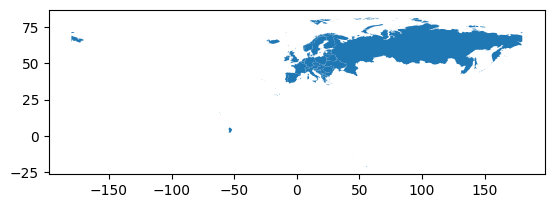

In [2]:
world = gpd.read_file('All Countries Shapefile/ne_50m_admin_0_countries.shp')
admin = world[world['CONTINENT'] == 'Europe']
admin.plot()

In [3]:
# Combine into one polygon
admin = admin.unary_union
admin = gpd.GeoDataFrame(geometry=[admin], crs=4326)
admin

C:\Users\User\AppData\Local\Temp\ipykernel_11676\2770707699.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  admin = admin.unary_union


,geometry
0,"MULTIPOLYGON (((-54.18809 2.87485, -54.1707 2...."


<Axes: >

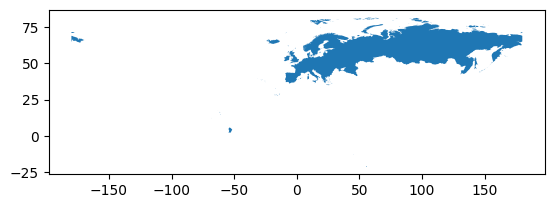

In [4]:
admin.plot()

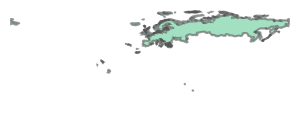

In [5]:
geom = admin.geometry.iloc[0]
geom

# Populate to hexagons

In [6]:
exterior = [(lat, lon) for lon, lat in geom.exterior.coords]

# Interior rings (holes), if any
holes = [
    [(lat, lon) for lon, lat in ring.coords]
    for ring in geom.interiors
]

h3_poly = LatLngPoly(exterior, holes)

resolution = 7  # ~3 km

hex_ids = h3.polygon_to_cells(h3_poly, resolution)

hex_polys = [
    Polygon([(lng, lat) for lat, lng in h3.cell_to_boundary(h)])
    for h in hex_ids
]

hex_gdf = gpd.GeoDataFrame(
    {"h3_id": list(hex_ids)},
    geometry=hex_polys,
    crs=4326
)

hex_gdf_m = hex_gdf.to_crs(32636)

len(hex_gdf)

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
hex_gdf.plot(ax=ax, color='lightgreen', edgecolor='darkgreen', linewidth=0.8)
admin.boundary.plot(ax=ax, color='black')
plt.title('Europe covered by H3 hexagons')
plt.show()

# Lebanon's Boundary

<Axes: >

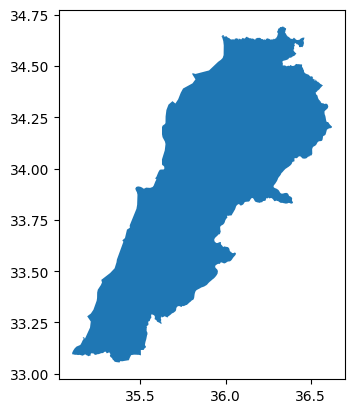

In [7]:
admin = ox.geocode_to_gdf("Lebanon")

# High-resolution land polygons (10m)
land = gpd.read_file(
    "https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip"
)

# Match CRS
land = land.to_crs(admin.crs)

# Clip marine territory
admin_leb = gpd.overlay(admin, land, how="intersection")

admin_leb.plot()

In [8]:
admin_leb # one polygon

,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name,featurecla,scalerank,min_zoom,geometry
0,34.882567,33.055033,36.625,34.692145,402318289,relation,184843,33.875063,35.843409,boundary,administrative,4,0.784945,country,Lebanon,Lebanon,Land,0.0,0.0,"POLYGON ((35.10151 33.09479, 35.10043 33.09569..."


In [9]:
admin_leb = admin_leb[['geometry']]
print(admin_leb.crs)
admin_leb

epsg:4326


,geometry
0,"POLYGON ((35.10151 33.09479, 35.10043 33.09569..."


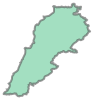

In [10]:
geom = admin_leb.geometry.iloc[0]
geom

# Populate to Hexagons

In [ ]:
from h3 import LatLngPoly

# Exterior ring
exterior = [(lat, lon) for lon, lat in geom.exterior.coords]

# Interior rings (holes), if any
holes = [
    [(lat, lon) for lon, lat in ring.coords]
    for ring in geom.interiors
]

h3_poly = LatLngPoly(exterior, holes)

resolution = 7  # ~3 km

hex_ids = h3.polygon_to_cells(h3_poly, resolution)

hex_polys = [
    Polygon([(lng, lat) for lat, lng in h3.cell_to_boundary(h)])
    for h in hex_ids
]

hex_gdf = gpd.GeoDataFrame(
    {"h3_id": list(hex_ids)},
    geometry=hex_polys,
    crs=4326
)

hex_gdf_m = hex_gdf.to_crs(32636)

len(hex_gdf)

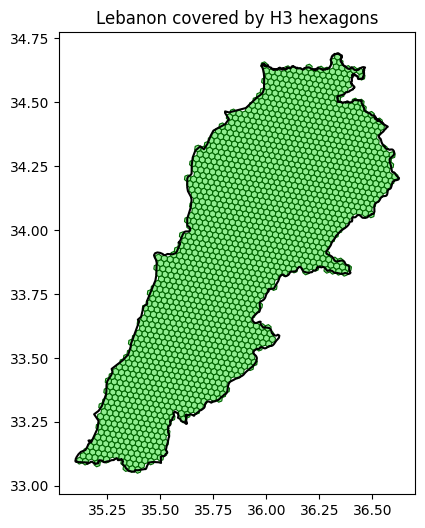

In [12]:
fig, ax = plt.subplots(figsize=(6,6))
hex_gdf.plot(ax=ax, color='lightgreen', edgecolor='darkgreen', linewidth=0.8)
admin_leb.boundary.plot(ax=ax, color='black')
plt.title('Lebanon covered by H3 hexagons')
plt.show()

# Download Lebanon's Population Data

In [13]:
# https://human-settlement.emergency.copernicus.eu/download.php?ds=pop

In [13]:
raster_path = '11. Raster Population/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R5_C22.tif'
raster = rasterio.open(raster_path)

In [17]:
print(hex_gdf.crs)
hex_gdf_r = hex_gdf.to_crs(raster.crs)
print(hex_gdf_r.crs)

EPSG:4326
PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [19]:
stats = rasterstats.zonal_stats(hex_gdf_r, raster_path, stats='sum', all_touched=True, progress_bar=True)

In [20]:
stats

[{'sum': 185.67600594181567},
 {'sum': 3627.878141157329},
 {'sum': 189.27006109431386},
 {'sum': 2882.2994029708207},
 {'sum': 0.0},
 {'sum': 0.0},
 {'sum': 2009.334337996319},
 {'sum': 1919.2999525405467},
 {'sum': 6806.4336153201},
 {'sum': 21.03962745174067},
 {'sum': 6071.948441416025},
 {'sum': 8087.76402433496},
 {'sum': 927.8656547777355},
 {'sum': 453.08970791473985},
 {'sum': 0.0},
 {'sum': 1692.993396602571},
 {'sum': 853.250102625927},
 {'sum': 765.0180879570544},
 {'sum': 5.899692535400391},
 {'sum': 0.0},
 {'sum': 838.3245335556567},
 {'sum': 1486.3066477165557},
 {'sum': 579.7898719497025},
 {'sum': 0.0},
 {'sum': 698.9328245585784},
 {'sum': 420.76873575663194},
 {'sum': 22.28352832607925},
 {'sum': 1318.5712577532977},
 {'sum': 8656.975516261766},
 {'sum': 199.39739221986383},
 {'sum': 0.0},
 {'sum': 0.0},
 {'sum': 10555.394716527313},
 {'sum': 0.0},
 {'sum': 145464.6108308665},
 {'sum': 4097.7337205614895},
 {'sum': 284.74168689223006},
 {'sum': 160.5345606021583},
 {

Text(0.5, 1.0, 'Hexagon-level Total Population (GHSL 2025, res=3)')

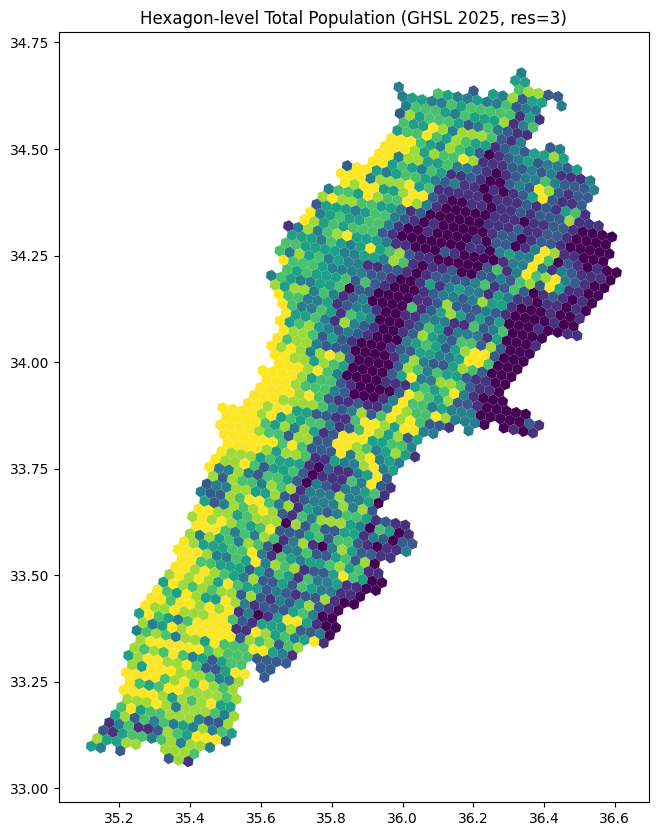

In [33]:
hex_gdf['pop_sum'] = [s['sum'] if s is not None else 0 for s in stats]
ax = hex_gdf.plot(column='pop_sum', cmap='viridis', figsize=(10, 10), scheme='quantiles', k=8)
ax.set_title('Hexagon-level Total Population (GHSL 2025, res=3)')

In [ ]:
# yellow most populated

# Hexagons to ASCII

In [26]:
chars = np.array(list(" .:-=+*#%@")) # increasing in pop
chars

array([' ', '.', ':', '-', '=', '+', '*', '#', '%', '@'], dtype='<U1')

In [34]:
value_counts = hex_gdf['pop_sum'].value_counts().sort_index()

value_counts

pop_sum
0.000000         182
0.002632           1
0.017482           1
0.018757           1
0.026256           1
                ... 
120763.888970      1
145464.610831      1
153935.306116      1
154465.029920      1
236279.139026      1
Name: count, Length: 1588, dtype: int64

In [37]:
vals = hex_gdf['pop_sum'].values

# Boolean mask for positive values
pos_mask = vals > 0

# Apply qcut only to positive values
bins = pd.qcut(
    vals[pos_mask],
    q=len(chars)-1,  # first char is reserved for zeros
    labels=chars[1:], 
    duplicates='drop'
)

# Initialize array with ' ' for zeros
ascii_chars = np.full(vals.shape, ' ', dtype=object)

# Assign ASCII characters to positive values
ascii_chars[pos_mask] = bins.astype(str)

# Add to GeoDataFrame
hex_gdf['ascii_char'] = ascii_chars

In [38]:
# Replace every hexagon by its center point to turn this map into a point map
hex_gdf['centroid'] = hex_gdf.geometry.centroid
hex_gdf.head(3)

C:\Users\User\AppData\Local\Temp\ipykernel_11676\498376281.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hex_gdf['centroid'] = hex_gdf.geometry.centroid


,h3_id,geometry,pop_sum,ascii_char,centroid
0,872d84850ffffff,"POLYGON ((36.32851 34.39969, 36.32613 34.38637...",185.676006,-,POINT (36.34111 34.39107)
1,872db1175ffffff,"POLYGON ((35.67229 33.38211, 35.67001 33.36871...",3627.878141,%,POINT (35.68486 33.37355)
2,872d84880ffffff,"POLYGON ((36.27556 34.18178, 36.27319 34.16844...",189.270061,-,POINT (36.28814 34.17317)


C:\Users\User\AppData\Local\Temp\ipykernel_11676\1028719770.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, c in zip(hex_gdf.centroid.x, hex_gdf.centroid.y, hex_gdf['ascii_char']):


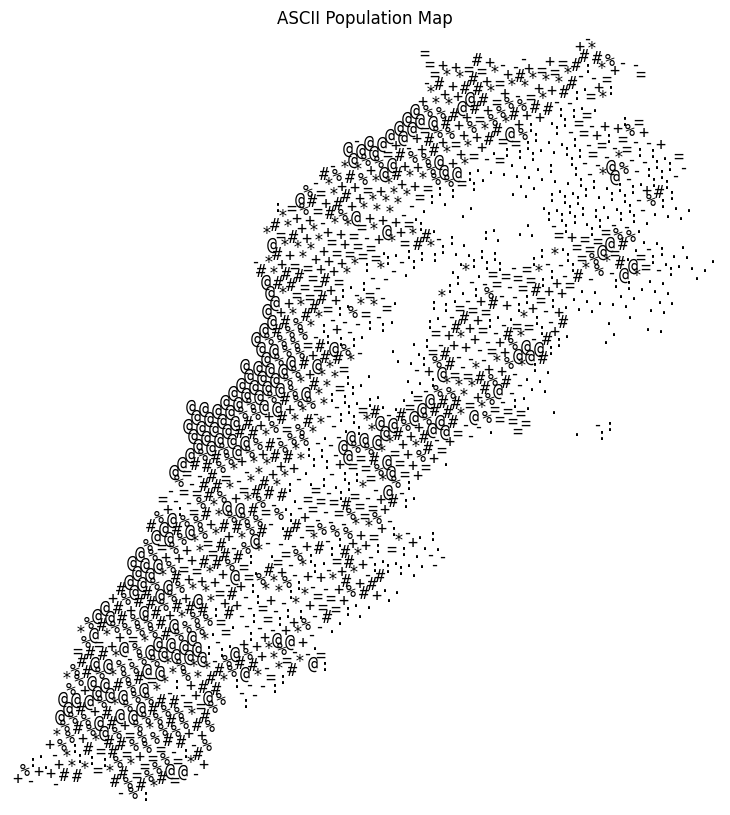

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))

for x, y, c in zip(hex_gdf.centroid.x, hex_gdf.centroid.y, hex_gdf['ascii_char']):
    ax.text(x, y, c, ha='center', va='center', fontsize=12, family='monospace', color='black')

minx, miny, maxx, maxy = hex_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

ax.set_aspect('equal')
ax.axis('off')
plt.title('ASCII Population Map')
plt.show()

# Coloring

C:\Users\User\AppData\Local\Temp\ipykernel_11676\2214785211.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, c in zip(hex_gdf.centroid.x, hex_gdf.centroid.y, hex_gdf['ascii_char']):


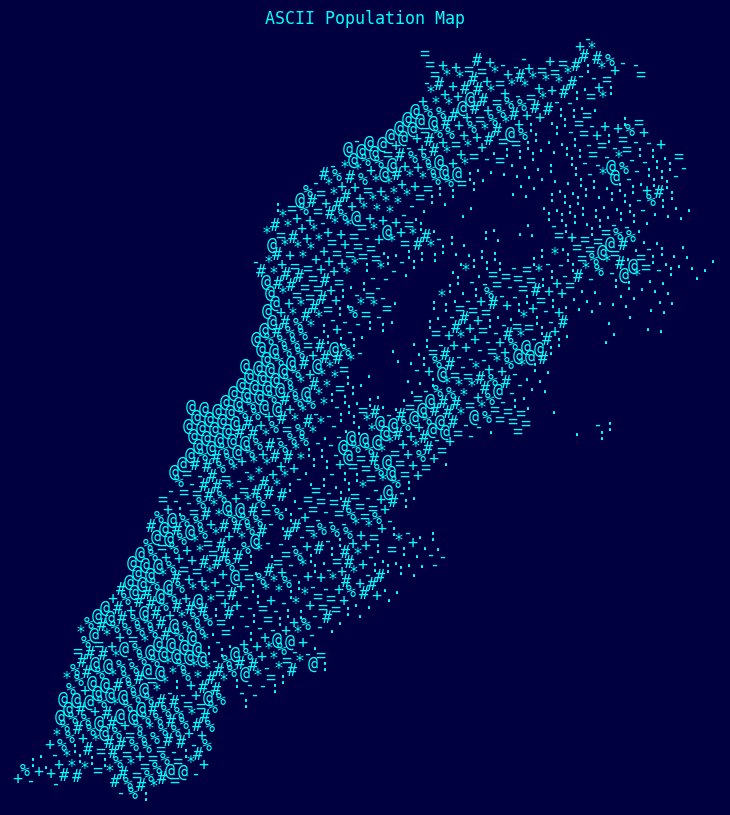

In [45]:
fig, ax = plt.subplots(figsize=(10, 10), facecolor='#000040')

for x, y, c in zip(hex_gdf.centroid.x, hex_gdf.centroid.y, hex_gdf['ascii_char']):
    ax.text(x, y, c, ha='center', va='center', fontsize=12, family='monospace', color='#00ffff')

minx, miny, maxx, maxy = hex_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

ax.set_facecolor('#00ffff')
ax.set_aspect('equal')
ax.axis('off')
plt.title('ASCII Population Map', color='#00ffff', fontsize=12, family='monospace')
plt.show()

In [46]:
from matplotlib import cm, colors

color_map = cm.get_cmap('turbo', len(chars))
hex_gdf['color'] = [color_map(i/len(chars)) for i in hex_gdf['ascii_char'].apply(lambda c: np.where(chars==c)[0][0])]
hex_gdf.head(3)

C:\Users\User\AppData\Local\Temp\ipykernel_11676\2450423098.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('turbo', len(chars))


,h3_id,geometry,pop_sum,ascii_char,centroid,color
0,872d84850ffffff,"POLYGON ((36.32851 34.39969, 36.32613 34.38637...",185.676006,-,POINT (36.34111 34.39107),"(0.10342, 0.896, 0.715, 1.0)"
1,872db1175ffffff,"POLYGON ((35.67229 33.38211, 35.67001 33.36871...",3627.878141,%,POINT (35.68486 33.37355),"(0.79125, 0.16368, 0.01387, 1.0)"
2,872d84880ffffff,"POLYGON ((36.27556 34.18178, 36.27319 34.16844...",189.270061,-,POINT (36.28814 34.17317),"(0.10342, 0.896, 0.715, 1.0)"


C:\Users\User\AppData\Local\Temp\ipykernel_11676\1644735375.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, c, color in zip(hex_gdf.centroid.x, hex_gdf.centroid.y, hex_gdf['ascii_char'], hex_gdf['color']):


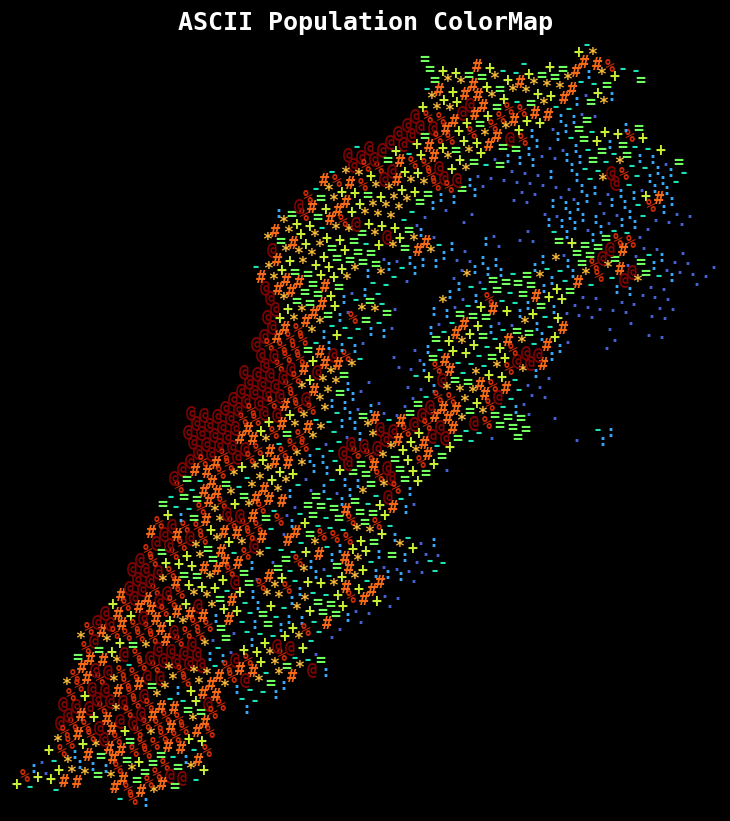

In [51]:
fig = plt.figure(figsize=(10, 10), facecolor='black')
ax = fig.add_subplot(111, facecolor='black')

for x, y, c, color in zip(hex_gdf.centroid.x, hex_gdf.centroid.y, hex_gdf['ascii_char'], hex_gdf['color']):
    ax.text(x, y, c, ha='center', va='center', fontsize=12, family='monospace', color=color, weight='bold')

minx, miny, maxx, maxy = hex_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

ax.set_aspect('equal')
ax.axis('off')
plt.title('ASCII Population ColorMap', color='white', fontsize=18, weight='bold', family='monospace')
plt.show()